In [51]:
# importing packages
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt

In [52]:
# loading the file into a dataframe
df = pd.read_csv('df_with_dummies_reduced.csv', index_col=0)
df.head()

,age,edu_years,hours_per_week,income_code,sex_code,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,race_Other,race_White,native_country_Asia,native_country_Central_AM,native_country_Europe,native_country_Middle_East,native_country_North_AM,native_country_SEA,native_country_South_AM,native_country_US
0,39,13,40,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,50,13,13,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
2,38,9,40,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,53,7,40,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,28,13,40,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


(29310, 47)
0    21984
1     7326
Name: income_code, dtype: int64


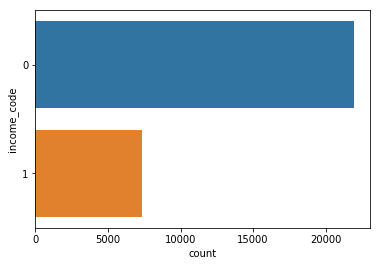

In [53]:
# assessing balance visually
print(df.shape)
print(df.income_code.value_counts())
sns.countplot(y=df['income_code'], data=df);
plt.savefig('balance.png')

In [4]:
# separating dependent and independent variables
y = df.income_code
X = df.drop(columns=['income_code'])
# Create a list of the features being used in the 
feature_cols = X.columns

In [5]:
# splitting the data
from sklearn.model_selection import train_test_split
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [6]:
# attempting logistic regression
from sklearn.linear_model import LogisticRegression

# dt_clf = DecisionTreeClassifier(max_depth=5)
lr_clf = LogisticRegression(solver='liblinear')

# dt_clf.fit(X_train, y_train)
lr_clf.fit(X_train, y_train)

# y_pred_test = dt_clf.predict(X_test)
y_pred_test = lr_clf.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, y_pred_test))

# checking accuracy
print('Test F1 score: ', f1_score(y_test, y_pred_test))

Test Accuracy score:  0.8329921528488571
Test F1 score:  0.6334706102583302


In [7]:
# concatenating training data back together for rebalancing 
training  = pd.concat([X_train, y_train], axis=1)
training.shape

(23448, 47)

In [8]:
len(X_train)

23448

In [9]:
# separate minority and majority classes
majority = training[training.income_code==0]
minority = training[training.income_code==1]

In [10]:
print('majority: '+ str(len(majority)))
print('minority: '+ str(len(minority)))

majority: 17608
minority: 5840


In [11]:
from imblearn.over_sampling import SMOTE

In [12]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

sm = SMOTE(random_state=23, ratio=1.0)

In [13]:
# sampling
X_train, y_train = sm.fit_sample(X_train, y_train)

In [14]:
len(X_train)

35216

In [15]:
# logistic regression after resampling
smote_lr = LogisticRegression(solver='liblinear')

# smote_dt.fit(X_train, y_train)
smote_lr.fit(X_train, y_train)

# smote_pred = smote_dt.predict(X_test)
smote_pred = smote_lr.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, smote_pred))

# checking accuracy
print('Test F1 score: ', f1_score(y_test, smote_pred))

Test Accuracy score:  0.827021494370522
Test F1 score:  0.6642384105960266


#### Improved by ~3%

## Decision tree performance w rebalanced data

In [17]:
# baseline decision tree
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

# training accuracy
y_pred_train_dt = clf.predict(X_train)

#Predict the response for test dataset
y_pred_tree_dt = clf.predict(X_test)

In [18]:
# CV for decision tree
# Import Grid search
from sklearn.model_selection import GridSearchCV
parameters={ 'max_depth': range(2,20,1)}
#create the instance of GridSearchCV
grid_tree=GridSearchCV(clf,parameters,  cv=5, scoring='f1')

#fit the Gridsearch to our data
grid_tree.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(2, 20)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='f1', verbose=0)

In [19]:
# examine the best model
# Single best score achieved across all params (min_samples_split)
print(grid_tree.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_tree.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_tree.best_estimator_)

0.848138926449698
{'max_depth': 13}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=13,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


## Random forrest w rebalanced data

In [20]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state = 23, n_estimators=100, max_depth=8)

In [21]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=23, verbose=0, warm_start=False)

In [22]:
rfc_pred = rfc.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, rfc_pred))

# checking accuracy
print('Test F1 score: ', f1_score(y_test, rfc_pred))

Test Accuracy score:  0.79136813374275
Test F1 score:  0.670616751952599


In [42]:
param_grid = { 
    'n_estimators': [200,300,400,800,1600,1800,2000],
    'max_depth' : [5,6,7,8,9,10,11,12,13,14,15,]
}

In [43]:
from sklearn.model_selection import RandomizedSearchCV

In [44]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid = param_grid, cv= 5,n_jobs=-1)
CV_rfc.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A

/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=23, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [200, 300, 400, 800, 1600, 1800, 2000], 'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [45]:
# looking at the best parameters
CV_rfc.best_params_

{'max_depth': 15, 'n_estimators': 1600}

In [46]:
# testing on the best parameters
rfc_pred_up = CV_rfc.best_estimator_.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, rfc_pred_up))

# checking accuracy
print('Test F1 score: ', f1_score(y_test, rfc_pred_up))

Test Accuracy score:  0.8132036847492323
Test F1 score:  0.6834345186470077


In [ ]:
### reduced by ~

In [ ]:
Test Accuracy score:  0.7988741044012283
Test F1 score:  0.6784837742023453